# In Class Exercise 6 

This exercise introduces a Deep Convolutional Generative Adversarial Network

We first import our framework. Since we are already familiar with pytorch, we will use the torch library. This will make it easy for us since we can use functions and classes other coders have already implemented.

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time


if not os.path.exists('./gan_img'):
    os.mkdir('./gan_img')



### Define the hyper-parameter and load the training dataset

hyperparameters we define in here

- img_size
- give your experiment a concise name
- batch_size (how big is one batch. This splits our dataset into equal pieces that we will feed into our neural network)
- train_epoch (How long will we train)
- learning rate
- dataset we will use

In [2]:
img_size = 32
train_epoch = 50
batch_size = 128
noise_size = 100
lr = 2e-4
experiment_name= 'TEST_noise'
experiment_path= './gan_img/{}'.format(experiment_name)

if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

img_transform = transforms.Compose([
transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=img_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Define the generator and discriminator

In here we are defining some functions that we will use later. Functions are very useful and you should write your functions whenever your code benefits from it. You should always declare your functions first in your script.

- normal_init (we will use this function to initialize our weights)
- show_result (outputs the images to a .png image)
- show the loss curve

In [4]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        
fixed_z_ = torch.randn((8 * 8, noise_size)).view(-1, noise_size, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda())

def show_result(num_epoch, show = False, save = False, isFix=False):
    z_ = torch.randn((8*8, noise_size)).view(-1, noise_size, 1, 1)
    z_ = Variable(z_)
    if torch.cuda.is_available():
        z_ = z_.cuda()
        
    G.eval()
    if isFix:
        with torch.no_grad():
            test_images = G(fixed_z_)
    else:
        with torch.no_grad():
            test_images = G(z_)
    G.train()
    
    pic = to_img(test_images.cpu().data)
    img_path= './gan_img/{}/output_{}.png'.format(experiment_name,num_epoch)
    save_image(pic,img_path)
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 32, 32)
    return x

def show_loss():
    pass

def time_convert(sec):
    mins = sec // 60
    sec = sec % 60
    hours = mins // 60
    mins = mins % 60
    print("Time Lapsed = {0} hours | {1} minutes | {2} seconds".format(int(hours),int(mins),sec))


### Define our Generator structure as a class

In [5]:
class generator(nn.Module):
    # initializers
    def __init__(self, input_size = 100, d=64):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(input_size, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))
        

        return x



### Define the discriminator class

In [6]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)
        

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

### Create an instance of our generator and discriminator

In [7]:
G = generator(input_size = noise_size)
D = discriminator()

G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

if torch.cuda.is_available():
    G.cuda()
    D.cuda()

print('###############################  Generator  ##################################\n',
      G,
      '\n######################################################################################\n\n')
print('##############################  Discriminator  ########################################\n',
      D,
      '\n######################################################################################')

BCE_loss = nn.BCELoss() 
#BCE_loss= nn.KLDivLoss(reduction='batchmean')

###############################  Generator  ##################################
 generator(
  (deconv1): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
) 
######################################################################################


##############################  Discriminator  ########################################
 discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv

In [8]:
# adding loss function (4-3)
def saturated_loss(DG_score):
  G_loss = torch.means(torch.log((1-DG_score) + 1e-8))
  return G_loss


def wgan_gp(D, interpolates, D_real, D_fake, flag):
  if flag == 'D':
    loss = -torch.mean(D_real) + torch.mean(D_fake)
    # wgan = loss.detach()
    wgan = loss

    x = D(interpolates)
    # print(x.shape)
    gradients = autograd.grad(outputs=x.sum(), inputs=interpolates,
                  create_graph=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    loss += 10*gradient_penalty

    return loss,wgan,(gradients.norm(2, dim=1)).mean()
  if flag == 'G':

    loss = -D_fake.mean()

    return loss

### Define which optimizer we will use for the optimization of our neural network
You can choose form the following

- AdaGrad
- SGD with and without momentum
- Adam

In [9]:
# D_optimizer = torch.optim.Adagrad(D.parameters(), lr=lr)
# G_optimizer = torch.optim.Adagrad(G.parameters(), lr=lr)

# D_optimizer = torch.optim.SGD(D.parameters(), lr=lr, momentum=0.9)
# G_optimizer = torch.optim.SGD(G.parameters(), lr=lr, momentum=0.9)

D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

### Start to training and save the reconstructed images


In [10]:
starttime=time.time()
for epoch in range(train_epoch):
    
    D_losses = []
    G_losses = []
    for i, (x_, _ )in enumerate(dataloader, 0):
        # train discriminator D
        D.zero_grad()
        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        
        x_, y_real_, y_fake_ = Variable(x_), Variable(y_real_), Variable(y_fake_)

        if torch.cuda.is_available():
            x_ = x_.cuda()
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()


        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)
        D_real_score = D_result

        z_ = torch.randn((mini_batch, noise_size)).view(-1, noise_size, 1, 1) #-1 in .view() means that the dimension is inferred from other dimensions
        z_ = Variable(z_)
        if torch.cuda.is_available():
            z_ = z_.cuda()
        G_result = G(z_)
        
        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.data)

        # train generator G

        G.zero_grad()
        
        z_ = torch.randn((mini_batch, noise_size)).view(-1, noise_size, 1, 1)


        z_ = Variable(z_)
        if torch.cuda.is_available():
            z_ = z_.cuda()

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        
        D_result_fake = D(G_result)

        # non-saturated loss
        # G_train_loss = BCE_loss(D_result, y_real_)
        # saturated-loss
        # G_train_loss = torch.mean(torch.log((1-D_result_fake) + 1e-8))
        #wgan-gp loss
        G_train_loss = wgan_gp(None, None, None, D_result_fake, 'G')

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data)


    print('[%d/%d]: Loss_D: %.3f, Loss_G: %.3f' % (
        (epoch+1), train_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    if epoch % 1 == 0:
        save_path = './gan_img/{}/output_{}.png'.format(experiment_name,epoch)
        show_result((epoch+1), save=True, isFix=True)
        
endtime=time.time()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/50]: Loss_D: 0.024, Loss_G: -0.005
[2/50]: Loss_D: 0.000, Loss_G: -0.000
[3/50]: Loss_D: 0.000, Loss_G: -0.000
[4/50]: Loss_D: 0.387, Loss_G: -0.042
[5/50]: Loss_D: 0.970, Loss_G: -0.290
[6/50]: Loss_D: 0.894, Loss_G: -0.286
[7/50]: Loss_D: 0.638, Loss_G: -0.204
[8/50]: Loss_D: 0.407, Loss_G: -0.121
[9/50]: Loss_D: 0.325, Loss_G: -0.092
[10/50]: Loss_D: 0.179, Loss_G: -0.059
[11/50]: Loss_D: 0.206, Loss_G: -0.054
[12/50]: Loss_D: 0.265, Loss_G: -0.066
[13/50]: Loss_D: 0.195, Loss_G: -0.052
[14/50]: Loss_D: 0.014, Loss_G: -0.007
[15/50]: Loss_D: 0.000, Loss_G: -0.000
[16/50]: Loss_D: 0.000, Loss_G: -0.000
[17/50]: Loss_D: 0.000, Loss_G: -0.000
[18/50]: Loss_D: 0.000, Loss_G: -0.000
[19/50]: Loss_D: 0.000, Loss_G: -0.000
[20/50]: Loss_D: 0.000, Loss_G: -0.000
[21/50]: Loss_D: 0.000, Loss_G: -0.000
[22/50]: Loss_D: 0.000, Loss_G: -0.000
[23/50]: Loss_D: 0.000, Loss_G: -0.000
[24/50]: Loss_D: 0.000, Loss_G: -0.000
[25/50]: Loss_D: 0.000, Loss_G: -0.000
[26/50]: Loss_D: 0.000, Loss_G: -0

### Let us have a look at the loss curve

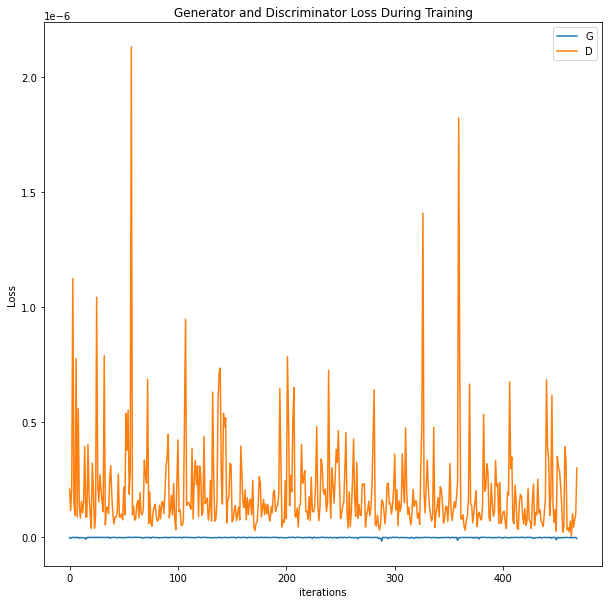

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figsize=(10,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
figurename=experiment_path +'/'+'losscurve.png'
plt.savefig(figurename,format='png')

### Let us take a look at the training time

In [12]:
time_convert(round(endtime-starttime))

Time Lapsed = 0 hours | 22 minutes | 23 seconds
